In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def CalibrateCamera():
    images=glob.glob('./camera_cal/calibration*.jpg')
    print(len(images))
    objpoints=[] #Real world coordinates 3D
    imgpoints=[]#Images points in 2D

    #Initializing initial object points
    objpts=np.zeros((6*9,3),np.float32)
    objpts[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)  #since we don't have z coordinates, restricting our array only till y coord
    #print(images)
    for file in images:
        #print(file)
        img=cv2.imread(file)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #print(gray.shape[::-1])

        #plt.imshow(gray)
        ret,corners=cv2.findChessboardCorners(gray,(9,6),None)

        if ret==True:
            #print('true')
            imgpoints.append(corners)
            objpoints.append(objpts)

            img1=cv2.drawChessboardCorners(img,(9,6),corners,ret)
            #plt.figure()
            #plt.imshow(img1)

    #ret,mtx,dist,rvects,tvects=cv2.calibrateCamera(objpoints,imgpoints,(1280,720),None,None)
    #print(dist)
    return cv2.calibrateCamera(objpoints,imgpoints,(1280,720),None,None)

In [18]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(50, 100)):
    # Calculate directional gradient
    # Apply threshold
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
   
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 90)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(image, sobel_kernel=13, thresh=(0.7,1.2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1 
    return binary_output

def s_threshold(img,s_thresh=(220, 230)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

def h_threshold(img,s_thresh=(40, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= s_thresh[0]) & (h_channel <= s_thresh[1])] = 1
    return h_binary

def r_threshold(img,s_thresh=(200, 255)):
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= s_thresh[0]) & (r_channel <= s_thresh[1])] = 1
    return r_binary


In [21]:
def ColorGradientBinary(img):
    img = np.copy(img)   
    
    # Threshold x gradient
    sxbinary = abs_sobel_thresh(img)
    
    # Threshold color channel
    s_binary = s_threshold(img)
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    mag_binary = mag_thresh(img)
    dir_binary = dir_threshold(img)
    r_binary = r_threshold(img)
    h_binary = h_threshold(img)
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (sxbinary == 1) | (h_binary == 1) ] = 1
    #combined_binary[(s_binary == 1) | (sxbinary == 1) |((mag_binary == 1) & (dir_binary == 1))] = 1
   
    #combined_binary[(s_binary == 1) | (sxbinary == 1) |((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[(((mag_binary == 1) & (dir_binary == 1) )& (sxbinary == 1)|(s_binary == 1))] = 1
    return combined_binary

In [5]:
def Undistortion(img,mtx,dist):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    dstr=cv2.undistort(img,mtx,dist,None,mtx)
    return dstr

In [6]:
def Wrap(img,dstr):
    #img=cv2.imread('test_images/'+file)
    #plt.subplot(len(images), 2, i)
    #i+=1
    #plt.imshow(img)
    #plt.imshow(dstr)
    img_size=img.shape
    src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 5) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32( [[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])

#     src=np.float32([[588,446],[691,446],[1100,673],[310,673]])
#     dst=np.float32([[100,0],[img_size[1]-100,0],[img_size[1]-100,img_size[0]],[100,img_size[0]]])
    
    m=cv2.getPerspectiveTransform(src,dst)
    
    #wrapped=cv2.warpPerspective(dstr,m,(img.shape[1],img.shape[0]),flags=cv2.INTER_LINEAR)
    grad=ColorGradientBinary(dstr)
    #plt.subplot(len(images), 2, i)
    #i+=1
    #plt.imshow(ColorGradientBinary(wrapped),cmap='gray')
    
    #return ColorGradientBinary(wrapped)
    return cv2.warpPerspective(grad,m,(img.shape[1],img.shape[0]),flags=cv2.INTER_LINEAR)
    
    #test=pipeline(ColorGradientBinary)
    #plt.imsave(arr=pipeline(ColorGradientBinary),fname="mytest/"+file,cmap='gray')    

In [32]:
def RadiusOfCurvature(ploty,left_fit,right_fit,leftx,rightx,lefty,righty):  
    y_eval=720
    midx = 650
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    #print(left_curverad, 'm', right_curverad, 'm')  
    
    curvature = (left_curverad+right_curverad)/2
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    cen_pos = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    
    return curvature,cen_pos
    # Example values: 632.1 m    626.2 m

In [35]:
def SlidingWindow(image,dstr,binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)



    #visualisation part

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    img_size=image.shape
    src = np.float32([[(img_size[1] / 2) - 55, img_size[0] / 2 + 100], [((img_size[1] / 5) - 10), img_size[0]], [(img_size[1] * 5 / 6) + 60, img_size[0]],[(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32( [[(img_size[1] / 4), 0], [(img_size[1] / 4), img_size[0]], [(img_size[1] * 3 / 4), img_size[0]], [(img_size[1] * 3 / 4), 0]])

#     src=np.float32([[588,446],[691,446],[1100,673],[310,673]])
#     dst=np.float32([[100,0],[img_size[1]-100,0],[img_size[1]-100,img_size[0]],[100,img_size[0]]])
    
    Minv=cv2.getPerspectiveTransform(dst,src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(dstr, 1, newwarp, 0.3, 0)   
    curvature,cen_pos = RadiusOfCurvature(ploty,left_fit,right_fit,leftx,rightx,lefty,righty)   
    cv2.putText(result, 'Radius of curvature: %.2fm' %curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1 , (255,255,255),2)
    
    if cen_pos < 0:
        text = 'right'
    else:
        text = 'left'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(cen_pos), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result
    #plt.imshow(result)

20


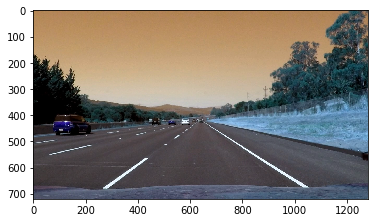

In [36]:
import os
images=os.listdir('test_images')

ret,mtx,dist,rvects,tvects = CalibrateCamera()
#for file in images:
img=cv2.imread('test_images/straight_lines2.jpg')
plt.imshow(img)
dstr=Undistortion(img,mtx,dist)
bin_img=Wrap(img,dstr)
res=SlidingWindow(img,dstr,bin_img)

In [9]:
ret,mtx,dist,rvects,tvects = CalibrateCamera()
def pipeling(img):
    dstr=Undistortion(img,mtx,dist)
    bin_img=Wrap(img,dstr)
    res=SlidingWindow(img,dstr,bin_img)
    return res

20


In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
import imageio 
#imageio.plugins.ffmpeg.download()

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeling(image)
    return cv2.cvtColor(result,cv2.COLOR_BGR2RGB)

In [39]:
# import os
# import matplotlib.image as mpimg
# import time
# for i in os.listdir('./myframe/'):
    
#     cv2.imwrite('./op1/'+str(time.time())+'.'+i.split('.')[1],cv2.cvtColor(process_image(mpimg.imread('./myframe/'+i)),cv2.COLOR_BGR2RGB))
#     #mpimg.imsave(arr=process_image(mpimg.imread('./myframe/'+i)),fname='./op/'+i)
#     print('/op/'+i)

In [38]:
white_output = 'mytest/result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video mytest/result.mp4
[MoviePy] Writing video mytest/result.mp4


100%|█████████▉| 1260/1261 [12:26<00:00,  1.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mytest/result.mp4 

CPU times: user 18min 52s, sys: 1min 2s, total: 19min 54s
Wall time: 12min 29s
